# Quick Look Validation Plots

In this notebook I'm developing a class to evaluate the source finding algorithms. The main metrics use here are completeness and contamination.


In [1]:
import numpy as np

import glob

from astropy.table import Table, join, vstack
from astropy.io import fits

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline


# Load Files

In [3]:
fnames = glob.glob('data/gaia_matched_*')
fnames[:5]

['data/gaia_matched_2021070700199.fits',
 'data/gaia_matched_2021070700177.fits',
 'data/gaia_matched_2021110400613.fits',
 'data/gaia_matched_2022031600689.fits',
 'data/gaia_matched_2020031400335.fits']

In [4]:
def get_expid(fname):
    return int(fname.split('.fits')[0][-13:])


In [5]:
table = Table(fits.getdata('gaia_matched_feb2020-nov2021_feb-march2022.fits'))

In [6]:
# tables = []
new_expIds = []
for i,fname in enumerate(fnames):
    # print(f'{i}: {fname}')
    # tables.append(Table(fits.getdata(fname)))
    new_expIds.append(get_expid(fname))
    
# table = vstack(tables)
# table.write('gaia_matched_feb2020-nov2021_feb-march2022.fits',format='fits',overwrite=True)

In [57]:
borders = 20
# xmin, xmax, ymin, ymax
edges = [0.,4070.,0.,4000.]

rect_mask = (table['ref_base_SdssCentroid_x']>= edges[0]+borders)&(table['ref_base_SdssCentroid_x']<= edges[1]-borders)
rect_mask &= (table['ref_base_SdssCentroid_x']>= edges[0]+borders)&(table['ref_base_SdssCentroid_x']<= edges[1]-borders)

In [58]:
## Define all masks

gaia = np.isfinite(table['ref_ra']) & rect_mask
auxtel = np.isfinite(table['base_SdssCentroid_x'])
only_gaia = np.isnan(table['base_CircularApertureFlux_3_0_instFlux']) & rect_mask
only_auxtel = (np.isnan(table['ref_ra']))
matched = (table['id_match']>0.) & rect_mask
good = (table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr'] > 5.) | only_gaia


In [59]:
len(table)

1182512

In [60]:
np.count_nonzero(matched)

211352

In [61]:
np.count_nonzero(gaia)

292610

In [62]:
np.count_nonzero(only_auxtel)

885291

In [63]:
np.count_nonzero(only_gaia)

80837

## Plot Distributions

In [199]:
mag = np.array(table['phot_g_mean_mag'])
flux = np.array(table['base_CircularApertureFlux_3_0_instFlux'])
log_flux = np.log10(flux)

flux[np.isnan(flux)] = -1.
log_flux[np.isnan(log_flux)] = -1.

flux_gt0 = log_flux>0.

snr = table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr']

/tmp/ipykernel_46957/438438145.py:3: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


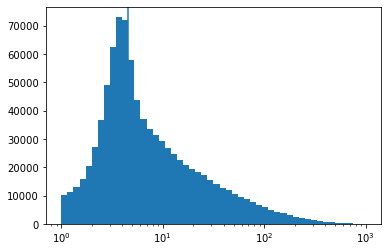

In [200]:
plt.hist(snr,bins=np.logspace(0.,3,51))
plt.axvline(4.5)
plt.xscale('log')

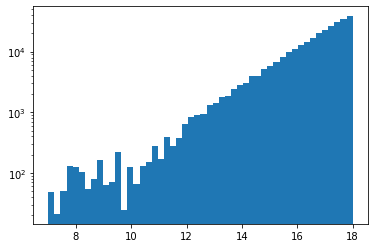

In [201]:
plt.hist(mag[gaia],bins=np.linspace(7,18,51))
plt.yscale('log')

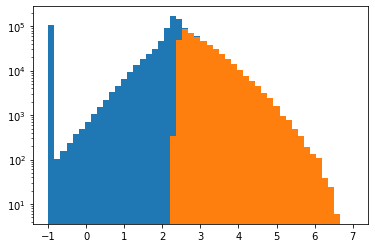

In [202]:
plt.hist(log_flux[auxtel],bins=np.linspace(-1,7.,51))
plt.hist(log_flux[auxtel&good],bins=np.linspace(-1.,7.,51))
plt.yscale('log')

## Compute Detection Rate

In [203]:
from utils import compute_fraction_err, plot_curve

In [106]:
mag_0 = 11.
mvec = np.arange(mag_0,18.+0.05,0.05)
m_frac = compute_fraction_err(mvec, mag[gaia], matched[gaia], bw=0.1, nBootStrap=100, error=False)
m_frac_mask = compute_fraction_err(mvec, mag[gaia&good], (matched)[gaia&good], bw=0.1, nBootStrap=100, error=False)

In [107]:
fvec = np.log10(np.logspace(1.,log_flux.max(),100))
frac_log = compute_fraction_err(fvec, log_flux[auxtel&flux_gt0], matched[auxtel&flux_gt0], bw=0.1, nBootStrap=100, error=False)
frac_log_mask = compute_fraction_err(fvec, log_flux[auxtel&good&flux_gt0], matched[auxtel&good&flux_gt0], bw=0.1, nBootStrap=100, error=False)


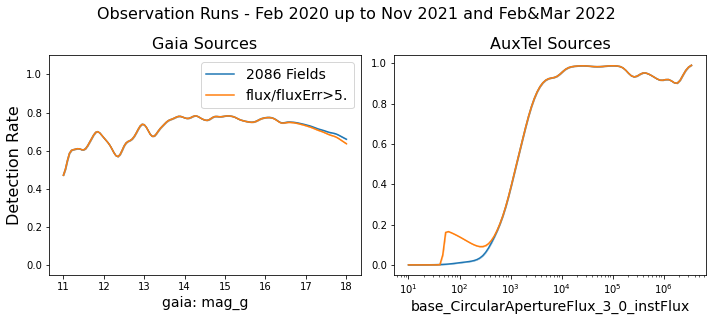

In [108]:
fig = plt.figure(figsize=(10,4.5))

plt.subplot(1, 2, 1)
plot_curve(mvec ,m_frac, label=f'{len(new_expIds)} Fields', ax=plt)
plot_curve(mvec ,m_frac_mask, label='flux/fluxErr>5.',ax=plt)
plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('Gaia Sources',fontsize=16)
#plt.tight_layout()
plt.ylim(-0.05,1.1)

plt.subplot(1, 2, 2)
plot_curve(10**fvec,frac_log,ax=plt)
plot_curve(10**fvec,frac_log_mask,ax=plt)
plt.xscale('log')
# plt.axhline(1)
# plt.legend(fontsize=14)
plt.xlabel('base_CircularApertureFlux_3_0_instFlux',fontsize=14)
# plt.ylabel('AuxTel Detection Rate',fontsize=16)
plt.title('AuxTel Sources',fontsize=16)
# plt.ylim(-0.05,1.1)
# plt.tight_layout()

fig.suptitle(f'Observation Runs - Feb 2020 up to Nov 2021 and Feb&Mar 2022',fontsize=16)
fig.tight_layout()
plt.savefig('auxtel_detection_rate_preliminary.png',facecolor='w',transparent=False,dpi=150)

## Cycles and CCD Filter

In [204]:
one = (table['EXPID'] < 2022010700000)
sep_up = (table['EXPID'] > 2021110100000)
feb = (table['EXPID'] > 2022010700000)&(table['EXPID'] < 2022030100000)
mar = (table['EXPID'] > 2022030100000)
feb_mar =  (table['EXPID'] > 2022010700000)

In [205]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins

In [60]:
bw=0.2
mvec = np.arange(mag_0,18.+bw/2.,bw/2.)
m_frac_one = compute_fraction_err(mvec, mag[gaia&one], matched[gaia&one], bw=bw, nBootStrap=100, error=True)
m_frac_feb = compute_fraction_err(mvec, mag[gaia&feb], matched[gaia&feb], bw=bw, nBootStrap=100, error=True)
m_frac_mar = compute_fraction_err(mvec, mag[gaia&mar], matched[gaia&mar], bw=bw, nBootStrap=100, error=True)


In [61]:
mDict = {'2020-2021':m_frac_one,'feb2022':m_frac_feb, 'mar2022':m_frac_mar}

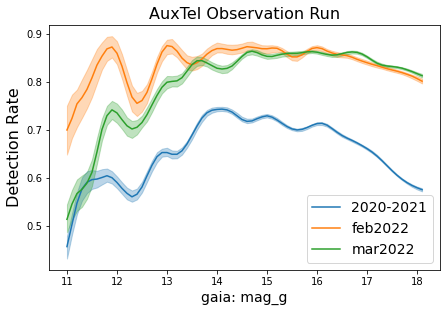

In [62]:
fig = plt.figure(figsize=(7,4.5))

for col in mDict.keys():
    plot_curve(mvec ,mDict[col], label=col, ax=plt)

plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('AuxTel Observation Run',fontsize=16)
#plt.tight_layout()
# plt.ylim(-0.05,1.1)
plt.savefig('auxtel_detection_rate_cycles.png',facecolor='w',transparent=False,dpi=150)

In [207]:
bw=0.2
mag_0 = 10.
mvec = np.arange(mag_0,18.+bw/2.,bw/2.)


In [405]:
RG610 = (table['FILTER']=='RG610')
FELH0600 = (table['FILTER']=='FELH0600')
SDSSg = (table['FILTER']=='SDSSg')
SDSSr = (table['FILTER']=='SDSSr')
SDSSi = (table['FILTER']=='SDSSi')

fDict = dict()
mask_list = {'RG610':RG610,'FELH0600':FELH0600,'SDSSg':SDSSg,'SDSSr':SDSSr,'SDSSi':SDSSi}
for li,mi in mask_list.items():
    print(f'{li}: {np.count_nonzero(mi)}')
    fDict[li] = compute_fraction_err(mvec, mag[gaia&mi], matched[gaia&mi], bw=bw, nBootStrap=100, error=True)

RG610: 408128
FELH0600: 162697
SDSSg: 299022
SDSSr: 131613
SDSSi: 109561


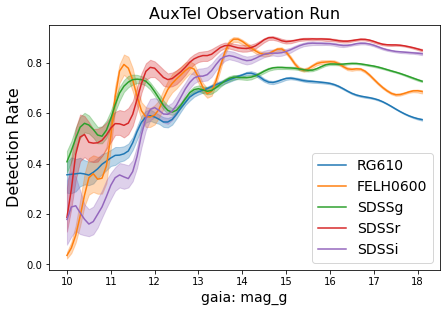

In [406]:
fig = plt.figure(figsize=(7,4.5))

for col in fDict.keys():
    plot_curve(mvec ,fDict[col], label=col, ax=plt)

plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('AuxTel Observation Run',fontsize=16)
#plt.tight_layout()
# plt.ylim(-0.05,1.1)
plt.savefig('auxtel_detection_rate_filters.png',facecolor='w',transparent=False,dpi=150)

In [211]:
RG610 = (table['FILTER']=='RG610')&sep_up
FELH0600 = (table['FILTER']=='FELH0600')&sep_up
SDSSg = (table['FILTER']=='SDSSg')&sep_up
SDSSr = (table['FILTER']=='SDSSr')&sep_up
SDSSi = (table['FILTER']=='SDSSi')&sep_up

fDict = dict()
mask_list = {'RG610':RG610,'FELH0600':FELH0600,'SDSSg':SDSSg,'SDSSr':SDSSr,'SDSSi':SDSSi}
for li,mi in mask_list.items():
    nsize = np.count_nonzero(mi)
    print(f'{li}: {nsize}')
    if nsize>10:
        fDict[li] = compute_fraction_err(mvec, mag[gaia&mi], matched[gaia&mi], bw=bw, nBootStrap=100, error=True)
        
print('done')

RG610: 0
FELH0600: 78423
SDSSg: 270291
SDSSr: 131613
SDSSi: 109561
done


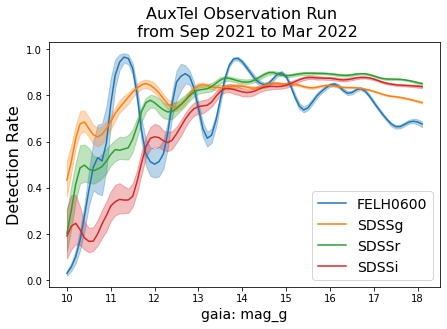

In [212]:
fig = plt.figure(figsize=(7,4.5))

for col in fDict.keys():
    plot_curve(mvec ,fDict[col], label=col, ax=plt)

plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('AuxTel Observation Run \n from Sep 2021 to Mar 2022',fontsize=16)
#plt.tight_layout()
# plt.ylim(-0.05,1.1)
plt.savefig('auxtel_detection_rate_filters.png',facecolor='w',transparent=False,dpi=150)

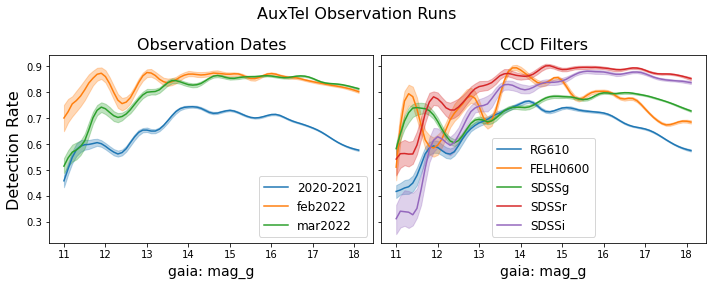

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.), sharex=True, sharey=True)

for col in mDict.keys():
    plot_curve(mvec ,mDict[col], label=col, ax=ax1)

ax1.legend(fontsize=12)
ax1.set_xlabel('gaia: mag_g',fontsize=14)
ax1.set_ylabel('Detection Rate',fontsize=16)
ax1.set_title('Observation Dates',fontsize=16)
# plt.ylim(0.3,0.92)

# plt.subplot(1, 2, 2)
for col in fDict.keys():
    plot_curve(mvec ,fDict[col], label=col, ax=ax2)
ax2.set_xlabel('gaia: mag_g',fontsize=14)
ax2.legend(fontsize=12)
ax2.set_title('CCD Filters',fontsize=16)
# plt.ylim(0.3,0.92)
fig.suptitle(f'AuxTel Observation Runs',fontsize=16)

fig.tight_layout()
fig.subplots_adjust(wspace=0.025)
plt.savefig('auxtel_detection_rate_cycle_filters_preliminary.png',facecolor='w',transparent=False,dpi=150)

In [7]:
table

base_SdssCentroid_x,base_SdssCentroid_y,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,ra,dec,gaia,id_match,source_id,ref_ra,ref_dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radius_val,ref_base_SdssCentroid_x,ref_base_SdssCentroid_y,dist,auxtel,EXPID,DATE,FILTER,EXPTIME,X0,Y0
float64,float64,float64,float64,float64,float64,bool,int64,int64,float64,float64,float32,float32,float32,float32,float64,float64,float64,bool,int64,str23,str8,float64,float64,float64
606.0,50.0,1085.82958984375,62.597721099853516,232.01483569757877,-6.39531062071859,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
3694.0,688.0,25.94661521911621,47.12056350708008,232.0217829274712,-6.47883874663546,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
2413.0,2777.0,15.264471054077148,45.306800842285156,232.08139804110758,-6.45174556382713,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
3938.0,2016.0,-24.47614097595215,41.890655517578125,232.05625859535854,-6.489541442885291,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
81.0,1137.0,4.619328022003174,49.9173469543457,232.04539411553384,-6.384949305388391,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
3170.022923185792,3076.6246511930785,-17.95151138305664,45.317684173583984,232.08690695897468,-6.472681844554192,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
3206.0,2104.0,-40.68539047241211,44.872989654541016,232.06096295995064,-6.470509521835003,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
2253.0,2608.0,-28.744688034057617,45.073158264160156,232.07742779118038,-6.446981455641728,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
3705.859220008616,2249.781562108288,14.966495513916016,42.78949737548828,232.06321755554998,-6.484166703463333,False,-2,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998


# Compute Detection Fraction Per Exposure

In [224]:
expids = np.array(table['EXPID'])
new_expids = np.unique(expids)

In [407]:
def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [408]:
keys = list(chunks(expids, new_expids))


In [409]:
def compute_frac_bins_per_exposure(mag, mag_bins, mask1, mask2, keys):
    mbins = 0.5*(mag_bins[1:]+mag_bins[:-1])

    frac = np.empty((len(mbins),len(keys)), dtype=float)
    for i,ix in enumerate(keys):
        denominator = np.histogram(mag[ix[mask1[ix]]],bins=mag_bins)[0]
        numerator   = np.histogram(mag[ix[mask2[ix]]],bins=mag_bins)[0]

        frac[:,i] = numerator/np.where(denominator<2,np.nan,denominator)

    return mbins, frac

In [410]:
fDict2 = dict()
mag_bins = np.linspace(10.2,18.,8)
mag_bins = np.array([9.,12.,14.0,15.0,16.0,17.,18.])
for li,mask in mask_list.items():
    mbins, frac = compute_frac_bins_per_exposure(mag, mag_bins, 
                                                 (gaia&mask), (matched&mask), keys)
    fDict2[li] = frac

In [455]:
mbins, frac = compute_frac_bins_per_exposure(mag, mag_bins, 
                                                 (gaia), (matched), keys)

In [411]:
def plot_bins(x, y, xerr, percentiles=[16,84],ax=None,color=None,**args):
    if ax is None: ax = plt.axes()
    
    ylow = np.nanpercentile(y,percentiles[0],axis=1)
    yhig = np.nanpercentile(y,percentiles[1],axis=1)
    ymean = np.nanmedian(y,axis=1)

    p = ax.errorbar(x, ymean, xerr=xerr, yerr=[ymean-ylow,yhig-ymean], 
                color=color, fmt='o', **args)
    return p[0].get_color()

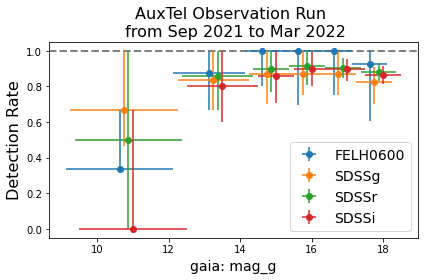

In [463]:
ax = plt.axes()
ax.axhline(1,color='gray',ls='--',lw=2)

i = 0
for col in fDict.keys():
    if i>0:
        color = plot_bins(mbins+0.125*i, fDict2[col], np.diff(mag_bins)/2., percentiles=[16,84], ax=ax, label=col)
        #plot_curve(mvec, fDict[col], ax=ax, color=color)
    i+=1
plt.legend(fontsize=14,loc=4)

plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('AuxTel Observation Run \n from Sep 2021 to Mar 2022',fontsize=16)
plt.tight_layout()
plt.savefig('auxtel_detection_rate_filters.png',facecolor='w',transparent=False,dpi=150)


'#d62728'

In [465]:
print('Number of exposures with det. rate > 95% at the band SDSSr')
n_high = np.empty((len(mbins),), dtype=float)
for i in range(len(mbins)):
    w, = np.where(fDict2['SDSSi'][i,:]>0.95)
    nbin = np.count_nonzero(~np.isnan(fDict2['SDSSr'][i,:]))
    n_high[i] = w.size
    print(f'{mag_bins[i]}: {int(n_high[i])}/{nbin}')

Number of exposures with det. rate > 95% at the band SDSSr
9.0: 4/74
12.0: 27/167
14.0: 30/174
15.0: 39/175
16.0: 23/177
17.0: 6/178


In [472]:
print('Number of exposures with det. rate < 50% at the band SDSSr')
indices_bad = []
for i in range(len(mbins)):
    w, = np.where(fDict2['SDSSi'][i,:]<0.50)
    nbin = np.count_nonzero(~np.isnan(fDict2['SDSSr'][i,:]))
    indices_bad.append(w)
    print(f'{mag_bins[i]}: {int(w.size)}/{nbin}')

Number of exposures with det. rate < 50% at the band SDSSr
9.0: 37/74
12.0: 3/167
14.0: 4/174
15.0: 2/175
16.0: 0/177
17.0: 2/178


In [476]:
new_expids[indices_bad[3]]

array([2022031700458, 2022031700459])

In [471]:
print('Number of exposures with det. rate > 90%')
n_high = np.empty((len(mbins),), dtype=float)
for i in range(len(mbins)):
    w, = np.where(frac[i,:]>0.90)
    nbin = np.count_nonzero(~np.isnan(frac[i,:]))
    n_high[i] = w.size
    print(f'{mag_bins[i]}: {int(n_high[i])}/{nbin}')
print(f'{mag_bins[i+1]}')

Number of exposures with det. rate > 90%
9.0: 167/669
12.0: 647/1608
14.0: 935/1798
15.0: 1025/1967
16.0: 1003/2042
17.0: 686/2072
18.0


In [381]:
# m_frac = compute_fraction_err(mvec, mag[gaia], matched[gaia], bw=0.1, nBootStrap=100, error=False)